In [46]:
from flask import Flask, request
from qiskit import *
from tqdm import tqdm

singlets_sent = 5
qcomp = Aer.get_backend("qasm_simulator")

In [47]:
def alice_measure(qc, basis): # basis = "X", "W" or "Z"
    """Alice's measurement circuits"""

    if basis == "X":  # X basis
        qc.h(0)
        qc.measure(0,0)

    elif basis == "W":  # W basis
        qc.s(0)
        qc.h(0)
        qc.t(0)
        qc.h(0)
        qc.measure(0,0)

    elif basis == "Z":  # Z basis
        qc.measure(0,0)

    else:
        raise ValueError("Value of parameter 'basis' can be one of 'X', 'W' or 'Z'")

    # result = list(execute(qc, qcomp, shots = 1).result().get_counts().keys())[0]
    result = execute(qc, qcomp, shots = 1000).result().get_counts()
    # if result[-1] == "1":
    #     return "1"
    # return "0"
    return result

In [48]:
def bob_measure(qc, basis): # basis = "W", "Z" or "V"
    """Bob's measurement circuits"""

    if basis == "W":  # W basis
        qc.s(1)
        qc.h(1)
        qc.t(1)
        qc.h(1)
        qc.measure(1,1)

    elif basis == "Z":  # Z basis
        qc.measure(1,1)

    elif basis == "V":  # V basis
        qc.s(1)
        qc.h(1)
        qc.tdg(1)
        qc.h(1)
        qc.measure(1,1)

    else:
        raise ValueError("Value of parameter 'basis' can be one of 'W', 'Z' or 'V'")

    # result = list(execute(qc, qcomp, shots = 1).result().get_counts().keys())[0]
    result = execute(qc, qcomp, shots = 1000).result().get_counts()
    # if result[-1] == "1":
    #     return "1"
    # return "0"
    return result

In [51]:
singlet = QuantumCircuit(2, 4, name='singlet')
singlet.x(0)
singlet.x(1)
singlet.h(0)
singlet.cx(0, 1)
alice_measure(singlet, "Z")
print(bob_measure(singlet, "Z"))

{'0001': 525, '0010': 475}


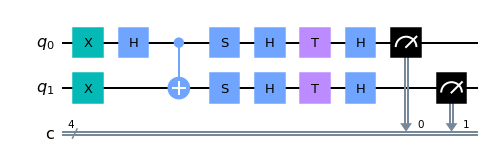

In [50]:
singlet.draw()

In [ ]:
ret = ""
bases = "XWXWZ"
for i, base in tqdm(enumerate(bases)):
    ret += f"{alice_measure(singlets[i], base)}|"

In [ ]:
# function that calculates CHSH correlation value
def chsh_corr(result):

    f = result.get_counts()

    # lists with the counts of measurement results
    # each element represents the number of (-1,-1), (-1,1), (1,-1) and (1,1) results respectively
    XW = [0, 0, 0, 0] # XW observable
    XV = [0, 0, 0, 0] # XV observable
    ZW = [0, 0, 0, 0] # ZW observable
    ZV = [0, 0, 0, 0] # ZV observable
    search = ["00", "01", "10", "11"]

    for i in range(singlets_sent):

        res = list(f[i].keys())[0]

        # if the spins of the qubits of the i-th singlet were projected onto the a_1/b_1 directions
        if (bases["alice"][i] == 1 and bases["bob"][i] == 1):
            for j in range(4):
                if res.endswith(search[j]):
                    XW[j] += 1

        if (bases["alice"][i] == 1 and bases["bob"][i] == 3):
            for j in range(4):
                if res.endswith(search[j]):
                    XV[j] += 1

        if (bases["alice"][i] == 3 and bases["bob"][i] == 1):
            for j in range(4):
                if res.endswith(search[j]):
                    ZW[j] += 1

        # if the spins of the qubits of the i-th singlet were projected onto the a_3/b_3 directions
        if (bases["alice"][i] == 3 and bases["bob"][i] == 3):
            for j in range(4):
                if res.endswith(search[j]):
                    ZV[j] += 1   

    # expectation values of XW, XV, ZW and ZV observables (2)
    expMaMa = (XW[0] - XW[1] - XW[2] + XW[3])/sum(XW) # -1/sqrt(2)
    expMaMc = (XV[0] - XV[1] - XV[2] + XV[3])/sum(XV) # 1/sqrt(2)
    expMcMa = (ZW[0] - ZW[1] - ZW[2] + ZW[3])/sum(ZW) # -1/sqrt(2)
    expMcMc = (ZV[0] - ZV[1] - ZV[2] + ZV[3])/sum(ZV) # -1/sqrt(2) 

    return expMaMa - expMaMc + expMcMa + expMcMc